<a href="https://colab.research.google.com/github/KaylumCassidy/SCMCA2/blob/main/SCMCA2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Supply Chain for Reduced Carbon Emissions (Aligned with SDG 13 - Climate Action) By Making ESG report on CO2 emissions of Distribution networks.  

How to create a Supply Chain Sustainability report?
Definition of CO2 emissions by Scope
Based on the GHG Protocol corporate standard (Link), greenhouse gas emissions are classified into three scopes:

Scope 1: direct emissions released into the atmosphere because of the company’s activities (Company’s facilities like manufacturing plant/warehouses, company’s vehicles)
Scope 2: indirect emissions from the generation of purchased energy
(purchased electricity, gas, ..)
Scope 3: all indirect emissions (out of scope 2) occurring in the value chain of the company (Transportation, Waste of Operations, Business Travels, …)
In this article, we will focus our attention on the Scope 3 calculations related to downstream transportation.

## Initial Datasets Import

### Import Shipped Order Lines

In [17]:
import pandas as pd
import warnings

In [18]:
df_lines = pd.read_csv('order_lines.csv', index_col = 0)
print("{:,} order lines to process".format(len(df_lines)))
df_lines.head()

5,208 order lines to process


,Date,Month-Year,Warehouse Code,Customer Code,Order Number,Order Line Number,Item Code,Units,Euros
112,2021-01-04 00:00:00.000,1-2021,3403434,5002915-15,20247100,1,963543-43,2.0,381.47
14485,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,1,8902753-53,250.0,187.03
14486,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,2,8308591-91,500.0,452.45
14487,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,3,8308621-21,500.0,452.45
14488,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,4,8022921-21,400.0,567.16


### Import Master Data: Unit of Measure Conversions to (kg)

In [19]:
df_uom = pd.read_csv('uom_conversions.csv', index_col = 0)
print("{:,} Unit of Measure Conversions".format(len(df_uom)))

# Join
df_join = df_lines.copy()
COLS_JOIN = ['Item Code']
df_join = pd.merge(df_join, df_uom, on=COLS_JOIN, how='left', suffixes=('', '_y'))
df_join.drop(df_join.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
print("{:,} records".format(len(df_join)))
df_join.head()

557 Unit of Measure Conversions
5,208 records


,Date,Month-Year,Warehouse Code,Customer Code,Order Number,Order Line Number,Item Code,Units,Euros,Conversion Ratio
0,2021-01-04 00:00:00.000,1-2021,3403434,5002915-15,20247100,1,963543-43,2.0,381.47,56.58400
1,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,1,8902753-53,250.0,187.03,0.03200
2,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,2,8308591-91,500.0,452.45,0.02219
3,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,3,8308621-21,500.0,452.45,0.02219
4,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,4,8022921-21,400.0,567.16,0.03200


### Import Distances

In [20]:

df_dist = pd.read_csv('distances.csv', index_col = 0)
# Location
df_dist['Location'] = df_dist['Customer Country'].astype(str) + ', ' + df_dist['Customer City'].astype(str)
df_dist.head()

,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Road,Rail,Sea,Air,Location
19,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,765.728,0.0,0.0,0.0,"FRANCE, LES ANGLES"
610,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE"
676,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,856.000,0.0,0.0,0.0,"GERMANY, PEINE - WOLTORF"
682,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,52.694,0.0,0.0,0.0,"FRANCE, BELLEVILLE"
1375,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5029913-13,FRANCE,MOISSY-CRAMAYEL,288.437,0.0,0.0,0.0,"FRANCE, MOISSY-CRAMAYEL"


### Import Cities GPS Locations

In [21]:
df_gps = pd.read_csv('gps_locations.csv', index_col = 0)
print("{:,} Locations".format(len(df_gps)))
df_gps.head()

19 Locations


,Location,GPS 1,GPS 2
867,"BULGARIA, DOLNI BOGROV",42.701462,23.490811
1087,"FRANCE, AUBROMETZ",50.303749,2.176058
1153,"FRANCE, BELLEVILLE",48.871184,2.386682
1371,"FRANCE, CLICHY CEDEX",48.904099,2.304123
1534,"FRANCE, GAEL",48.116682,-2.234640


## Data Processing

### Merge Distance with GPS Location

In [22]:
df_dist = pd.merge(df_dist, df_gps, on='Location', how='left', suffixes=('', '_y'))
df_dist.drop(df_dist.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
df_dist

,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Road,Rail,Sea,Air,Location,GPS 1,GPS 2
0,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,765.728,0.0,0.0,0.0,"FRANCE, LES ANGLES",42.579678,2.048950
1,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
2,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,856.000,0.0,0.0,0.0,"GERMANY, PEINE - WOLTORF",52.304594,10.312521
3,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,52.694,0.0,0.0,0.0,"FRANCE, BELLEVILLE",48.871184,2.386682
4,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5029913-13,FRANCE,MOISSY-CRAMAYEL,288.437,0.0,0.0,0.0,"FRANCE, MOISSY-CRAMAYEL",48.624666,2.595756
5,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003451-51,FRANCE,LEVALLOIS PERRET,295.165,0.0,0.0,0.0,"FRANCE, LEVALLOIS PERRET",48.894640,2.287419
6,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5293132-32,FRANCE,HERLIN LE SEC,353.590,0.0,0.0,0.0,"FRANCE, HERLIN LE SEC",50.354429,2.331766
7,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003269-69,FRANCE,MACON,478.723,0.0,0.0,0.0,"FRANCE, MACON",48.878552,2.280117
8,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003474-74,FRANCE,ORLY,287.110,0.0,0.0,0.0,"FRANCE, ORLY",48.740227,2.402965
9,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003476-76,FRANCE,VITRY SUR SEINE,284.851,0.0,0.0,0.0,"FRANCE, VITRY SUR SEINE",48.789263,2.395103


In [23]:
COLS_JOIN = ['Warehouse Code', 'Customer Code']
df_join = pd.merge(df_join, df_dist, on = COLS_JOIN, how='left', suffixes=('', '_y'))
df_join.drop(df_join.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
print("{:,} records".format(len(df_join)))
df_join

5,208 records


,Date,Month-Year,Warehouse Code,Customer Code,Order Number,Order Line Number,Item Code,Units,Euros,Conversion Ratio,...,Warehouse City,Customer Country,Customer City,Road,Rail,Sea,Air,Location,GPS 1,GPS 2
0,2021-01-04 00:00:00.000,1-2021,3403434,5002915-15,20247100,1,963543-43,2.0,381.47,56.58400,...,CHALONS-EN-CHAMPAGNE,FRANCE,LES ANGLES,765.728,0.0,0.0,0.0,"FRANCE, LES ANGLES",42.579678,2.048950
1,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,1,8902753-53,250.0,187.03,0.03200,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
2,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,2,8308591-91,500.0,452.45,0.02219,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
3,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,3,8308621-21,500.0,452.45,0.02219,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
4,2021-01-07 00:00:00.000,1-2021,3403434,5397843-43,20258239,4,8022921-21,400.0,567.16,0.03200,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5203,2021-10-28 00:00:00.000,10-2021,3403434,5397843-43,21089497,84,802065-65,80.0,72.96,0.02200,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
5204,2021-10-28 00:00:00.000,10-2021,3403434,5397843-43,21089497,85,942082-82,200.0,391.88,0.03200,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
5205,2021-10-28 00:00:00.000,10-2021,3403434,5397843-43,21089497,86,8022922-22,400.0,581.40,0.03200,...,CHALONS-EN-CHAMPAGNE,FRANCE,SUCY EN BRIE,281.488,0.0,0.0,0.0,"FRANCE, SUCY EN BRIE",48.768810,2.537369
5206,2021-11-01 00:00:00.000,10-2021,3403434,5340669-69,21004473,1,982884-84,2000.0,2980.00,0.14600,...,CHALONS-EN-CHAMPAGNE,GERMANY,PEINE - WOLTORF,856.000,0.0,0.0,0.0,"GERMANY, PEINE - WOLTORF",52.304594,10.312521


Add Unit of Measure Conversions
The next step is to convert the quantities ordered into weight (kg).

Net Weight vs. Total Weight
Before going into the details of the calculation, we need to explain the difference between gross and net weight.

In [25]:
# Calculate Weight (KG) with a check for Conversion Ratio
df_join['KG'] = df_join['Units'] * df_join['Conversion Ratio'].replace(0, 1)  # Replace 0 with 1 to avoid division by zero

# Agg by order
GPBY_ORDER = ['Date', 'Month-Year',
        'Warehouse Code', 'Warehouse Name', 'Warehouse Country', 'Warehouse City',
        'Customer Code', 'Customer Country', 'Customer City', 'Location', 'GPS 1', 'GPS 2',
        'Road', 'Rail', 'Sea', 'Air',
        'Order Number']
df_agg = pd.DataFrame(df_join.groupby(GPBY_ORDER)[['Units', 'KG']].sum())
df_agg.reset_index(inplace=True)
df_agg.head()


,Date,Month-Year,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Location,GPS 1,GPS 2,Road,Rail,Sea,Air,Order Number,Units,KG
0,2021-01-04 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,"FRANCE, LES ANGLES",42.579678,2.048950,765.728,0.0,0.0,0.0,20247100,2.0,113.16800
1,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,"GERMANY, PEINE - WOLTORF",52.304594,10.312521,856.000,0.0,0.0,0.0,20203388,153.0,2530.32471
2,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",48.871184,2.386682,52.694,0.0,0.0,0.0,20203383,128.0,2116.87296
3,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",48.768810,2.537369,281.488,0.0,0.0,0.0,20258239,2771.0,71.45232
4,2021-01-08 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003451-51,FRANCE,LEVALLOIS PERRET,"FRANCE, LEVALLOIS PERRET",48.894640,2.287419,295.165,0.0,0.0,0.0,21000061,2125.0,111.95200


### Calculate CO2 = f(KG, Ratios)

In [27]:

# CO2 Emissions
dict_co2e = dict(zip(['Air' ,'Sea', 'Road', 'Rail'], [2.1, 0.01, 0.096, 0.028]))
MODES = ['Road', 'Rail','Sea', 'Air']
for mode in MODES:
    df_agg['CO2 ' + mode] = df_agg['KG'].astype(float)/1000 * df_agg[mode].astype(float) * dict_co2e[mode]
df_agg['CO2 Total'] = df_agg[['CO2 ' + mode for mode in MODES]].sum(axis = 1)
df_agg.head()

,Date,Month-Year,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Location,...,Sea,Air,Order Number,Units,KG,CO2 Road,CO2 Rail,CO2 Sea,CO2 Air,CO2 Total
0,2021-01-04 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,"FRANCE, LES ANGLES",...,0.0,0.0,20247100,2.0,113.16800,8.318967,0.0,0.0,0.0,8.318967
1,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,"GERMANY, PEINE - WOLTORF",...,0.0,0.0,20203388,153.0,2530.32471,207.931963,0.0,0.0,0.0,207.931963
2,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",...,0.0,0.0,20203383,128.0,2116.87296,10.708464,0.0,0.0,0.0,10.708464
3,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",...,0.0,0.0,20258239,2771.0,71.45232,1.930845,0.0,0.0,0.0,1.930845
4,2021-01-08 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003451-51,FRANCE,LEVALLOIS PERRET,"FRANCE, LEVALLOIS PERRET",...,0.0,0.0,21000061,2125.0,111.95200,3.172254,0.0,0.0,0.0,3.172254


### Final mapping for visualization

In [28]:

# Mapping the delivery Mode
df_agg['Delivery Mode'] = df_agg[MODES].astype(float).apply(
    lambda t: [mode if t[mode]>0 else '-' for mode in MODES], axis = 1)
dict_map = dict(zip(df_agg['Delivery Mode'].astype(str).unique(),
  [i.replace(", '-'",'').replace("'-'",'').replace("'",'') for i in df_agg['Delivery Mode'].astype(str).unique()]))
df_agg['Delivery Mode'] = df_agg['Delivery Mode'].astype(str).map(dict_map)
df_agg

,Date,Month-Year,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Location,...,Air,Order Number,Units,KG,CO2 Road,CO2 Rail,CO2 Sea,CO2 Air,CO2 Total,Delivery Mode
0,2021-01-04 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,"FRANCE, LES ANGLES",...,0.0,20247100,2.0,113.16800,8.318967,0.0,0.000000,0.0,8.318967,[Road]
1,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,"GERMANY, PEINE - WOLTORF",...,0.0,20203388,153.0,2530.32471,207.931963,0.0,0.000000,0.0,207.931963,[Road]
2,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",...,0.0,20203383,128.0,2116.87296,10.708464,0.0,0.000000,0.0,10.708464,[Road]
3,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",...,0.0,20258239,2771.0,71.45232,1.930845,0.0,0.000000,0.0,1.930845,[Road]
4,2021-01-08 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003451-51,FRANCE,LEVALLOIS PERRET,"FRANCE, LEVALLOIS PERRET",...,0.0,21000061,2125.0,111.95200,3.172254,0.0,0.000000,0.0,3.172254,[Road]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2021-10-26 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",...,0.0,21004398,9040.0,416.74880,2.108175,0.0,0.000000,0.0,2.108175,[Road]
287,2021-10-27 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5029913-13,FRANCE,MOISSY-CRAMAYEL,"FRANCE, MOISSY-CRAMAYEL",...,0.0,21089663,13515.0,493.52420,13.665661,0.0,0.000000,0.0,13.665661,[Road]
288,2021-10-27 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5334855-55,UNITED KINGDOM,KENT,"UNITED KINGDOM, KENT",...,0.0,21009276,450.0,35.34930,1.387955,0.0,0.015554,0.0,1.403509,"[Road, Sea]"
289,2021-10-28 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",...,0.0,21089497,11831.0,367.71380,9.936674,0.0,0.000000,0.0,9.936674,[Road]


CO2 Emissions Calculations using Emissions Factors
Final Calculation of the CO2 Emissions
We have now all the information needed to be gathered in a single data frame. We can start to calculate the CO2 emissions using emissions factors associated with your transportation network.

Sum the weight by Order
For reporting purposes, let us calculate the CO2 emissions for each order number (linked with a customer and a date).



In [44]:
# Calculate Weight (KG)
df_join['KG'] = df_join['Units'] * df_join['Conversion Ratio']
# Agg by order
GPBY_ORDER = ['Date', 'Month-Year',
        'Warehouse Code', 'Warehouse Name', 'Warehouse Country', 'Warehouse City',
        'Customer Code', 'Customer Country', 'Customer City','Location', 'GPS 1', 'GPS 2',
        'Road', 'Rail', 'Sea', 'Air',
        'Order Number']
df_agg = pd.DataFrame(df_join.groupby(GPBY_ORDER)[['Units', 'KG']].sum())
df_agg.reset_index(inplace = True)
# CO2 Emissions Calculation
dict_co2e = dict(zip(['Air' ,'Sea', 'Road', 'Rail'], [2.1, 0.01, 0.096, 0.028]))
MODES = ['Road', 'Rail','Sea', 'Air']
for mode in MODES:
    df_agg['CO2 ' + mode] = df_agg['KG'].astype(float)/1000 * df_agg[mode].astype(float) * dict_co2e[mode]
df_agg['CO2 Total'] = df_agg[['CO2 ' + mode for mode in MODES]].sum(axis = 1)
# Mapping the delivery Mode
df_agg['Delivery Mode'] = df_agg[MODES].astype(float).apply(
    lambda t: [mode if t[mode]>0 else '-' for mode in MODES], axis = 1)
dict_map = dict(zip(df_agg['Delivery Mode'].astype(str).unique(),
  [i.replace(", '-'",'').replace("'-'",'').replace("'",'') for i in df_agg['Delivery Mode'].astype(str).unique()]))
df_agg['Delivery Mode'] = df_agg['Delivery Mode'].astype(str).map(dict_map)

In [45]:
df_agg

,Date,Month-Year,Warehouse Code,Warehouse Name,Warehouse Country,Warehouse City,Customer Code,Customer Country,Customer City,Location,...,Air,Order Number,Units,KG,CO2 Road,CO2 Rail,CO2 Sea,CO2 Air,CO2 Total,Delivery Mode
0,2021-01-04 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5002915-15,FRANCE,LES ANGLES,"FRANCE, LES ANGLES",...,0.0,20247100,2.0,113.16800,8.318967,0.0,0.000000,0.0,8.318967,[Road]
1,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340669-69,GERMANY,PEINE - WOLTORF,"GERMANY, PEINE - WOLTORF",...,0.0,20203388,153.0,2530.32471,207.931963,0.0,0.000000,0.0,207.931963,[Road]
2,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",...,0.0,20203383,128.0,2116.87296,10.708464,0.0,0.000000,0.0,10.708464,[Road]
3,2021-01-07 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",...,0.0,20258239,2771.0,71.45232,1.930845,0.0,0.000000,0.0,1.930845,[Road]
4,2021-01-08 00:00:00.000,1-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5003451-51,FRANCE,LEVALLOIS PERRET,"FRANCE, LEVALLOIS PERRET",...,0.0,21000061,2125.0,111.95200,3.172254,0.0,0.000000,0.0,3.172254,[Road]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2021-10-26 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5340672-72,FRANCE,BELLEVILLE,"FRANCE, BELLEVILLE",...,0.0,21004398,9040.0,416.74880,2.108175,0.0,0.000000,0.0,2.108175,[Road]
287,2021-10-27 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5029913-13,FRANCE,MOISSY-CRAMAYEL,"FRANCE, MOISSY-CRAMAYEL",...,0.0,21089663,13515.0,493.52420,13.665661,0.0,0.000000,0.0,13.665661,[Road]
288,2021-10-27 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5334855-55,UNITED KINGDOM,KENT,"UNITED KINGDOM, KENT",...,0.0,21009276,450.0,35.34930,1.387955,0.0,0.015554,0.0,1.403509,"[Road, Sea]"
289,2021-10-28 00:00:00.000,10-2021,3403434,WAREHOUSE PARIS AREA 1,FRANCE,CHALONS-EN-CHAMPAGNE,5397843-43,FRANCE,SUCY EN BRIE,"FRANCE, SUCY EN BRIE",...,0.0,21089497,11831.0,367.71380,9.936674,0.0,0.000000,0.0,9.936674,[Road]


## Save Final Report


In [46]:
# Save Final Report
df_agg.to_csv('final_report.csv')

## Final report map

In [33]:
!pip install plotly geopandas



In [37]:
# Check unique values in the 'Location' column of df_agg
print("Unique values in df_agg['Location']:")
print(df_agg['Location'].unique())

# Check unique values in the 'name' column of the Europe GeoDataFrame
print("\nUnique values in europe['name']:")
print(europe['name'].unique())


Unique values in df_agg['Location']:
['FRANCE, LES ANGLES' 'GERMANY, PEINE - WOLTORF' 'FRANCE, BELLEVILLE'
 'FRANCE, SUCY EN BRIE' 'FRANCE, LEVALLOIS PERRET'
 'FRANCE, MOISSY-CRAMAYEL' 'FRANCE, HERLIN LE SEC' 'FRANCE, MACON'
 'FRANCE, ORLY' 'FRANCE, VITRY SUR SEINE' 'FRANCE, CLICHY CEDEX'
 'FRANCE, SERRIS' 'UNITED KINGDOM, BRISTOL' 'FRANCE, AUBROMETZ'
 'FRANCE, GAEL' 'UNITED KINGDOM, KENT' 'FRANCE, GRETZ ARMAINVILLIERS'
 'BULGARIA, DOLNI BOGROV' 'MAURITANIA, NOUAKCHOTT']

Unique values in europe['name']:
['Russia' 'Norway' 'France' 'Sweden' 'Belarus' 'Ukraine' 'Poland'
 'Austria' 'Hungary' 'Moldova' 'Romania' 'Lithuania' 'Latvia' 'Estonia'
 'Germany' 'Bulgaria' 'Greece' 'Albania' 'Croatia' 'Switzerland'
 'Luxembourg' 'Belgium' 'Netherlands' 'Portugal' 'Spain' 'Ireland' 'Italy'
 'Denmark' 'United Kingdom' 'Iceland' 'Slovenia' 'Finland' 'Slovakia'
 'Czechia' 'Bosnia and Herz.' 'North Macedonia' 'Serbia' 'Montenegro'
 'Kosovo']


In [39]:
import plotly.express as px

# Assuming df_agg has the necessary data including latitude, longitude, and CO2 emissions
fig = px.scatter_geo(df_agg,
                     locations="Location",
                     locationmode="country names",
                     color="CO2 Total",
                     hover_name="Location",
                     size="CO2 Total",
                     projection="natural earth",
                     title="CO2 Emissions by Location")

fig.show()



What if you don’t have 100% of the distance?
A major challenge here is to get the distances if you have several thousand delivery locations.

If you are not able to collect 100% of the distance from your carriers, you can:

Get the road distances using Google Maps API / OR
Estimate the distance using the Haversine formula / OR
Compute the average distance of your top customers (in Euros) and apply the average to the locations without distances
3. What if you don’t have 100% of the weight conversions?
In some cases, the master data is not updated and you cannot get the unit-of-measure conversions for all the items.

In that case, you can

Focus your data collection efforts on the high runners (turnover)
Estimate the weight per euro for these items (kg/euros)
Apply the average ratio on the c remaining items without conversions to get their weight

## Visualization

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


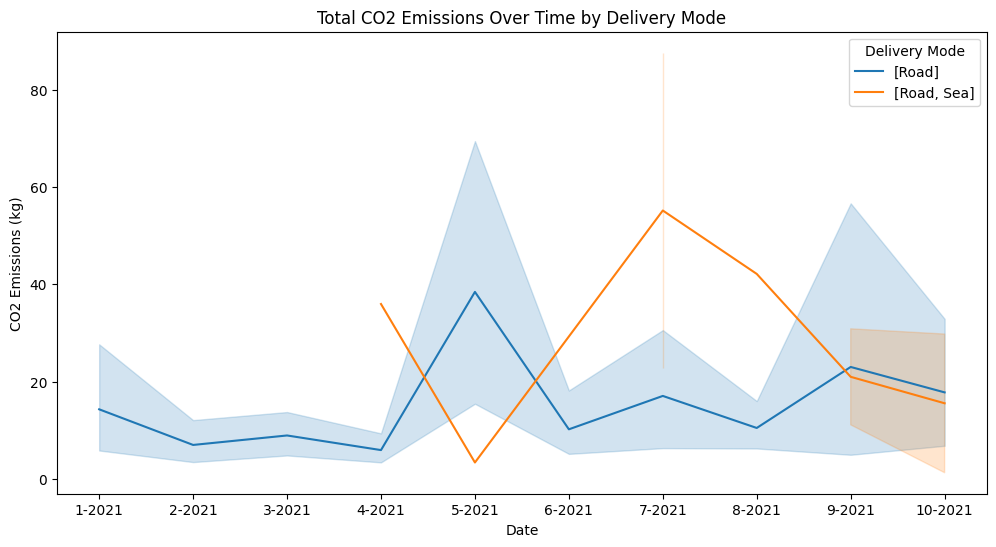

In [50]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_agg, x='Month-Year', y='CO2 Total', hue='Delivery Mode')
plt.title('Total CO2 Emissions Over Time by Delivery Mode')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions (kg)')
plt.show()


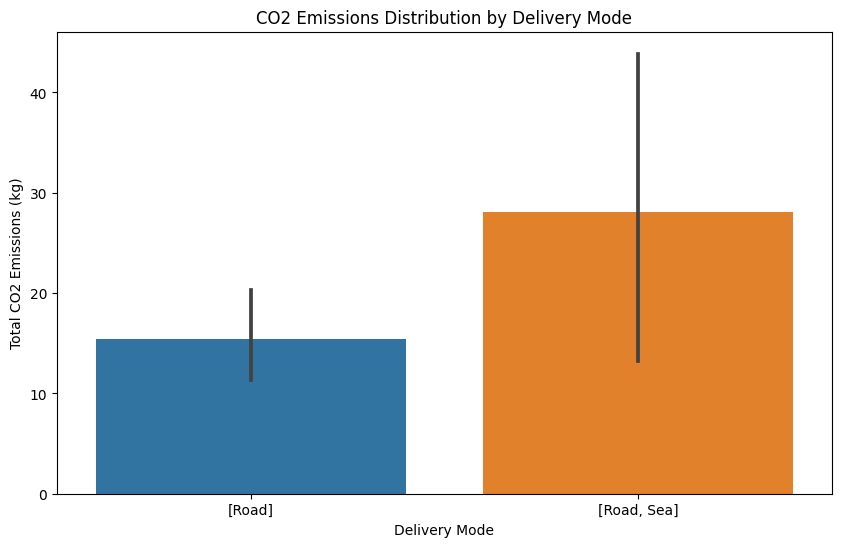

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_agg, x='Delivery Mode', y='CO2 Total')
plt.title('CO2 Emissions Distribution by Delivery Mode')
plt.xlabel('Delivery Mode')
plt.ylabel('Total CO2 Emissions (kg)')
plt.show()
